In [1]:
from model import NNmodel as nModel

from model import NNmodel as nModel
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from data_loader import dataset_Block as dB
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np


     

In [3]:

data_dir = "/Net/elnino/data/obs/ERA5/global/daily/"
train_year = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009]
test_year = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
offsets = range(1,13) # (1,13)

train_ds_indices =  [(yr, off) for yr in train_year for off in offsets]
test_ds_indices = [(yr, off) for yr in test_year for off in offsets]

train_data = dB.NetCDFDataset(data_dir,train_year,offsets,variables=["tp"])
val_data = dB.NetCDFDataset(data_dir,test_year,offsets,variables=["tp"])

     
train_ds_sampler = SubsetRandomSampler(train_ds_indices)
test_ds_sampler = SubsetRandomSampler(test_ds_indices)
train_loader = DataLoader(train_data, batch_size=32, sampler=train_ds_sampler)
val_loader = DataLoader(val_data, batch_size=32, sampler=test_ds_sampler)

In [7]:
# Define the linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # Input dimension is 1, output dimension is 1

    def forward(self, x):
        x = x.unsqueeze(1)
        return self.linear(x)

In [12]:
# Initialize the model, loss function, and optimizer
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            val_losses.append(val_loss.item())
    val_loss = np.mean(val_losses)

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}')


/conda/aoleksy/miniconda/envs/aioeast12/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/conda/aoleksy/miniconda/envs/aioeast12/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/500], Training Loss: 17.2379, Validation Loss: 13.6461
Epoch [20/500], Training Loss: 19.2564, Validation Loss: 12.0677
Epoch [30/500], Training Loss: 14.5402, Validation Loss: 11.7351
Epoch [40/500], Training Loss: 11.0138, Validation Loss: 12.0176
Epoch [50/500], Training Loss: 11.4859, Validation Loss: 14.0648
Epoch [60/500], Training Loss: 10.8881, Validation Loss: 12.2115
Epoch [70/500], Training Loss: 15.7631, Validation Loss: 12.0852
Epoch [80/500], Training Loss: 10.9192, Validation Loss: 12.0018
Epoch [90/500], Training Loss: 10.2448, Validation Loss: 12.1135
Epoch [100/500], Training Loss: 11.7140, Validation Loss: 11.7315
Epoch [110/500], Training Loss: 15.4770, Validation Loss: 12.3501
Epoch [120/500], Training Loss: 14.7386, Validation Loss: 11.7446
Epoch [130/500], Training Loss: 7.5403, Validation Loss: 12.1456
Epoch [140/500], Training Loss: 18.2992, Validation Loss: 11.7856
Epoch [150/500], Training Loss: 7.7390, Validation Loss: 11.6459
Epoch [160/500], Trai

In [32]:
train_losses = []
val_losses = []


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 12)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()  # Since targets are integers, use CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, targets in train_loader:
        targets = targets - 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())  # Squeeze to remove extra dim, cast targets to long
        loss.backward()
        optimizer.step()

    # Print the training loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}')

    train_losses.append(loss.item())

    all_predictions = []
    all_targets = []


    # Validation phase
    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            targets = targets - 1
            outputs = model(inputs)
            val_loss = criterion(outputs, targets.squeeze().long())
            val_losses.append(val_loss.item())
            predictions = torch.argmax(outputs, dim=1) + 1  # Convert class indices back to original target values
            all_predictions.extend(predictions.tolist())
            all_targets.extend(targets.tolist())
    val_loss = np.mean(val_losses)
    val_losses.append(val_loss)

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

# Combine predictions and targets into pairs
prediction_target_pairs = list(zip(all_predictions, all_targets))

# Print the first few prediction-target pairs
print("Prediction-Target Pairs:")
for i in range(5):
    print(prediction_target_pairs[i])

Epoch [10/100], Training Loss: 1.7404
Epoch [10/100], Validation Loss: 1.7494
Epoch [20/100], Training Loss: 1.4411
Epoch [20/100], Validation Loss: 1.6428
Epoch [30/100], Training Loss: 1.6901
Epoch [30/100], Validation Loss: 1.5921
Epoch [40/100], Training Loss: 1.4831
Epoch [40/100], Validation Loss: 1.5076
Epoch [50/100], Training Loss: 1.3540
Epoch [50/100], Validation Loss: 1.4562
Epoch [60/100], Training Loss: 1.3351
Epoch [60/100], Validation Loss: 1.4127
Epoch [70/100], Training Loss: 1.3097
Epoch [70/100], Validation Loss: 1.3929
Epoch [80/100], Training Loss: 1.2317
Epoch [80/100], Validation Loss: 1.3589
Epoch [90/100], Training Loss: 1.2807
Epoch [90/100], Validation Loss: 1.3474
Epoch [100/100], Training Loss: 1.2140
Epoch [100/100], Validation Loss: 1.3238
Prediction-Target Pairs:
(3, 3.0)
(10, 8.0)
(5, 3.0)
(10, 9.0)
(9, 7.0)


In [39]:
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()  # Since targets are integers, use CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

# Training loop
num_epochs = 250
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, targets in train_loader:
        targets = targets - 1
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())  # Squeeze to remove extra dim, cast targets to long
        loss.backward()
        optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    # Validation phase
    model.eval()
    val_loss_epoch = 0.0  # Accumulator for epoch's validation loss
    with torch.no_grad():
        all_predictions = []
        all_targets = []
        for inputs, targets in val_loader:
            targets = targets - 1
            outputs = model(inputs)
            val_loss_batch = criterion(outputs, targets.squeeze().long())
            val_loss_epoch += val_loss_batch.item()  # Accumulate validation loss per batch

            # Store predictions and targets for later analysis
            predictions = torch.argmax(outputs, dim=1) + 1  # Convert class indices back to original target values
            all_predictions.extend(predictions.tolist())
            all_targets.extend(targets.tolist())

    # Calculate average validation loss for the epoch and store it
    val_loss_epoch /= len(val_loader)
    val_losses.append(val_loss_epoch)

    # Print the training and validation losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss_epoch:.4f}')

# Combine predictions and targets into pairs
prediction_target_pairs = list(zip(all_predictions, all_targets))

# Print the first few prediction-target pairs
print("Prediction-Target Pairs:")
for i in range(5):
    print(prediction_target_pairs[i])

Epoch [10/250], Training Loss: 1.6138, Validation Loss: 1.8085
Epoch [20/250], Training Loss: 1.7058, Validation Loss: 1.7062
Epoch [30/250], Training Loss: 1.7206, Validation Loss: 1.6533
Epoch [40/250], Training Loss: 1.5206, Validation Loss: 1.6009
Epoch [50/250], Training Loss: 1.6580, Validation Loss: 1.5615
Epoch [60/250], Training Loss: 1.3383, Validation Loss: 1.5226
Epoch [70/250], Training Loss: 1.4272, Validation Loss: 1.4912
Epoch [80/250], Training Loss: 1.4043, Validation Loss: 1.4595
Epoch [90/250], Training Loss: 1.2369, Validation Loss: 1.4387
Epoch [100/250], Training Loss: 1.2590, Validation Loss: 1.4115
Epoch [110/250], Training Loss: 1.2233, Validation Loss: 1.4036
Epoch [120/250], Training Loss: 1.2430, Validation Loss: 1.3701
Epoch [130/250], Training Loss: 1.1418, Validation Loss: 1.3678
Epoch [140/250], Training Loss: 1.1616, Validation Loss: 1.3477
Epoch [150/250], Training Loss: 1.1798, Validation Loss: 1.3328
Epoch [160/250], Training Loss: 1.2625, Validatio

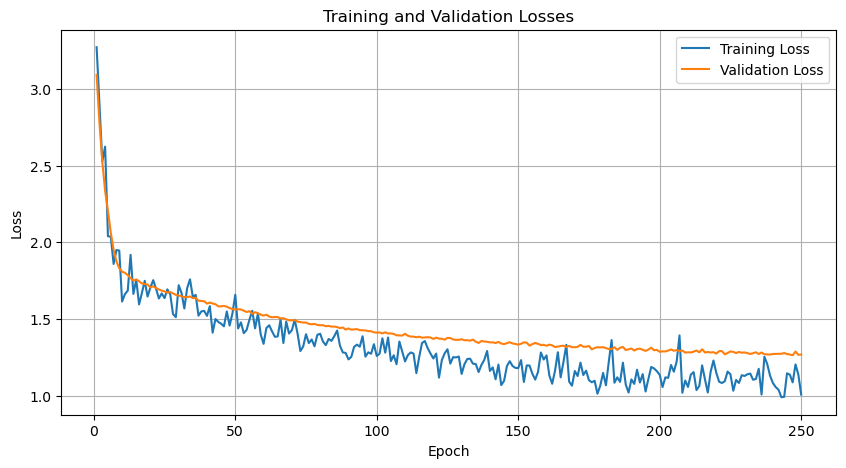

In [40]:
# Plot loss vs epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        #self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 12)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.fc1(x)
        #x = self.relu(x)
        x = self.fc2(x)
        return x

model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()  # Since targets are integers, use CrossEntropyLoss
criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store training and validation losses
train_losses = []
val_losses = []

all_val_pairs = []

# Training loop
num_epochs = 250
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, targets in train_loader:
        targets = targets - 1
        optimizer.zero_grad()
        outputs = model(inputs)

        #print("Outputs shape:", outputs.shape)
        #print("Targets shape:", targets.shape)

        loss = criterion(outputs, targets.squeeze().long())  # Squeeze to remove extra dim, cast targets to long
        loss.backward()
        optimizer.step()

    # Store training loss
    train_losses.append(loss.item())

    if (epoch + 1) % 10 == 0:
        # Validation phase
        model.eval()
        val_loss_epoch = 0.0  # Accumulator for epoch's validation loss
        with torch.no_grad():
            all_predictions = []
            all_targets = []
            for inputs, targets in val_loader:
                targets = targets - 1
                outputs = model(inputs)
                
                #targets = targets.unsqueeze(1).expand(-1, outputs.shape[1])

                #print("Outputs shape:", outputs.shape)
                #print("Targets shape:", targets.shape)
                val_loss_batch = criterion(outputs, targets.squeeze().long())
                val_loss_epoch += val_loss_batch.item()  # Accumulate validation loss per batch

                # Store predictions and targets for later analysis
                predictions = torch.argmax(outputs, dim=1) + 1  # Convert class indices back to original target values
                all_predictions.extend(predictions.tolist())
                all_targets.extend(targets.tolist())

        # Calculate average validation loss for the epoch and store it
        val_loss_epoch /= len(val_loader)
        val_losses.append(val_loss_epoch)

    # Print the training and validation losses every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss_epoch:.4f}')
    all_val_pairs.append((all_predictions, all_targets))

# Combine predictions and targets into pairs
prediction_target_pairs = list(zip(all_predictions, all_targets))

# Print the first few prediction-target pairs
print("Prediction-Target Pairs:")
print("Length: ", len(prediction_target_pairs))
for i in range(5):
    print(prediction_target_pairs[i])

Epoch [10/250], Training Loss: 1.6682, Validation Loss: 1.8227
Epoch [20/250], Training Loss: 1.6451, Validation Loss: 1.7208
Epoch [30/250], Training Loss: 1.6718, Validation Loss: 1.6538
Epoch [40/250], Training Loss: 1.5874, Validation Loss: 1.6072
Epoch [50/250], Training Loss: 1.5341, Validation Loss: 1.5527
Epoch [60/250], Training Loss: 1.4916, Validation Loss: 1.5072
Epoch [70/250], Training Loss: 1.4520, Validation Loss: 1.4714
Epoch [80/250], Training Loss: 1.4088, Validation Loss: 1.4425
Epoch [90/250], Training Loss: 1.3165, Validation Loss: 1.4177
Epoch [100/250], Training Loss: 1.3455, Validation Loss: 1.4017
Epoch [110/250], Training Loss: 1.3774, Validation Loss: 1.3797
Epoch [120/250], Training Loss: 1.3356, Validation Loss: 1.3663
Epoch [130/250], Training Loss: 1.2713, Validation Loss: 1.3438
Epoch [140/250], Training Loss: 1.1571, Validation Loss: 1.3333
Epoch [150/250], Training Loss: 1.3198, Validation Loss: 1.3183
Epoch [160/250], Training Loss: 1.1666, Validatio

In [38]:
# Extract the numbers from the pairs
numbers1, numbers2 = zip(*prediction_target_pairs)

# Convert the numbers to numpy arrays for easy computation
numbers1 = np.array(numbers1)
numbers2 = np.array(numbers2)

# Calculate the squared differences
squared_diff = (numbers1 - numbers2) ** 2

# Compute the mean squared error
mse = np.mean(squared_diff)

print("Mean Squared Error:", mse)

Mean Squared Error: 1.875


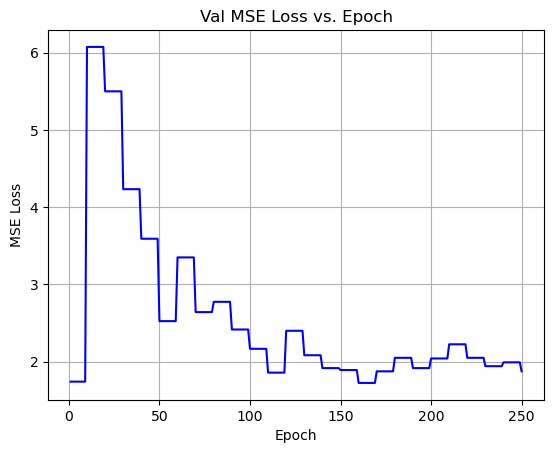

In [37]:
val_mses = []
for i in range(len(all_val_pairs)):
    # Extract the numbers from the pairs
    numbers1 = all_val_pairs[i][0]
    numbers2 = all_val_pairs[i][1]

    # Convert the numbers to numpy arrays for easy computation
    numbers1 = np.array(numbers1)
    numbers2 = np.array(numbers2)

    # Calculate the squared differences
    squared_diff = (numbers1 - numbers2) ** 2

    # Compute the mean squared error
    mse = np.mean(squared_diff)
    val_mses.append(mse)

    indices = range(1, len(val_mses) + 1)


# Plot the values with a line plot
plt.plot(indices, val_mses, color='blue', linestyle='-')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Val MSE Loss vs. Epoch')

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
# Plot loss vs epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
data_dir = "/Net/elnino/data/obs/ERA5/global/daily/"
train_year = [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009]
test_year = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
offsets = range(1,40) # (1,13)

train_data = dB.NetCDFDataset(data_dir,train_year,offsets,variables=["tp"])
val_data = dB.NetCDFDataset(data_dir,test_year,offsets,variables=["tp"])

train_loaders = []
val_loaders = []

for n in range (10,41):
    train_ds_indices =  [(yr, off) for yr in train_year for off in offsets[:n]]
    test_ds_indices = [(yr, off) for yr in test_year for off in offsets[:n]]
        
    train_ds_sampler = SubsetRandomSampler(train_ds_indices)
    test_ds_sampler = SubsetRandomSampler(test_ds_indices)
    train_loader = DataLoader(train_data, batch_size=32, sampler=train_ds_sampler)
    val_loader = DataLoader(val_data, batch_size=32, sampler=test_ds_sampler)

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        #self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 12)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.fc1(x)
        #x = self.relu(x)
        x = self.fc2(x)
        return x

model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()  # Since targets are integers, use CrossEntropyLoss
criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

final_mses = []
off_mse_pairs = []
for n in range(0,31):
    # Initialize lists to store training and validation losses
    train_losses = []
    val_losses = []

    all_val_pairs = []

    # Training loop
    num_epochs = 250
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for inputs, targets in train_loaders[n]:
            targets = targets - 1
            optimizer.zero_grad()
            outputs = model(inputs)

            #print("Outputs shape:", outputs.shape)
            #print("Targets shape:", targets.shape)

            loss = criterion(outputs, targets.squeeze().long())  # Squeeze to remove extra dim, cast targets to long
            loss.backward()
            optimizer.step()

        # Store training loss
        train_losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            # Validation phase
            model.eval()
            val_loss_epoch = 0.0  # Accumulator for epoch's validation loss
            with torch.no_grad():
                all_predictions = []
                all_targets = []
                for inputs, targets in val_loaders[n]:
                    targets = targets - 1
                    outputs = model(inputs)
                    
                    #targets = targets.unsqueeze(1).expand(-1, outputs.shape[1])

                    #print("Outputs shape:", outputs.shape)
                    #print("Targets shape:", targets.shape)
                    val_loss_batch = criterion(outputs, targets.squeeze().long())
                    val_loss_epoch += val_loss_batch.item()  # Accumulate validation loss per batch

                    # Store predictions and targets for later analysis
                    predictions = torch.argmax(outputs, dim=1) + 1  # Convert class indices back to original target values
                    all_predictions.extend(predictions.tolist())
                    all_targets.extend(targets.tolist())
                all_val_pairs.append((all_predictions, all_targets))
                prediction_target_pairs = list(zip(all_predictions, all_targets))

            # Calculate average validation loss for the epoch and store it
            val_loss_epoch /= len(val_loader)
            val_losses.append(val_loss_epoch)

        # Print the training and validation losses every 10 epochs
        #if (epoch + 1) % 10 == 0:
         #   print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss_epoch:.4f}')
        

    # Combine predictions and targets into pairs
    

    # Print the first few prediction-target pairs
    #print("Prediction-Target Pairs:")
    #print("Length: ", len(prediction_target_pairs))
    #for i in range(5):
    #    print(prediction_target_pairs[i])


    val_mses = []
    for i in range(len(all_val_pairs)):
        # Extract the numbers from the pairs
        numbers1 = all_val_pairs[i][0]
        numbers2 = all_val_pairs[i][1]

        # Convert the numbers to numpy arrays for easy computation
        numbers1 = np.array(numbers1)
        numbers2 = np.array(numbers2)

        # Calculate the squared differences
        squared_diff = (numbers1 - numbers2) ** 2

        # Compute the mean squared error
        mse = np.mean(squared_diff)
        val_mses.append(mse)

        indices = range(1, len(val_mses) + 1)

    final_mse = val_mses[-1]
    off_mse_pair = [n+10, final_mse]
    final_mses.append(final_mse)
    off_mse_pairs.append(off_mse_pair)
print("Done")

IndexError: Target 12 is out of bounds.